# Sentimen Analisis Model Eng

In [1]:
from gensim.models import Doc2Vec
import re
import os
import pandas as pd
import numpy as np
import multiprocessing
import ipython_genutils
import pickle
import progressbar
import tensorflow as tf
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D,GRU,LSTM
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn import utils
from sklearn.utils import shuffle
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Using TensorFlow backend.


### load file csv

target
1. negative = -1
2. neutral = 0
3. positive = 1

In [2]:
df = pd.read_csv('lib/clean_text.csv',index_col=0)
df['target']=df['target'].map({0:-1,1:0,2:1})
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df = shuffle(df)
df.info()
df.head()

C:\Users\Kurniawan\Anaconda3\envs\nlp\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1620947 entries, 1596198 to 1064138
Data columns (total 2 columns):
text      1620947 non-null object
target    1620947 non-null int64
dtypes: int64(1), object(1)
memory usage: 37.1+ MB


,text,target
1596198,fli lax sfo system let check site tell tell,-1
1323467,hope know everyon support media shit stupid pe...,1
926106,mine great ate good mother seen ya pic cute,1
510179,wht hahhh,-1
90318,school tomorrow perform wish harmonuium come end,-1


### jumlah data tiap class

In [3]:
df.groupby('target')['text'].count()

target
-1    814047
 0      6227
 1    800673
Name: text, dtype: int64

### downsampling dataset ke jumlah class terkecil

In [4]:
dneg=df.query('target == -1')
dnet=df.query('target == 0')
dpos=df.query('target == 1')

minlen=min(len(dnet.index),len(dpos.index),len(dneg.index))

dnet=dnet.head(minlen)
dneg=dneg.head(minlen)
dpos=dpos.head(minlen)

data_training=pd.concat([dneg.text,dnet.text,dpos.text])
target=pd.concat([dneg.target,dnet.target,dpos.target])
target=to_categorical(target-target.min())

### tanpa downsampling

In [5]:
data_training=df.text
target=df.target
target=to_categorical(target-target.min())

In [6]:
df_ds=pd.DataFrame({'text':data_training,'target':np.argmax(target, axis=1, out=None)})
df_ds.groupby('target')['text'].count()

target
0    814047
1      6227
2    800673
Name: text, dtype: int64


### tokenizing

create tokenizer lalu di save ada/dibuat tokenizer. jika sudah dibuat maka skip langsung ke load tokenizer

In [7]:
#save tokenizer
#data_training=df.text
#tokenizer = Tokenizer(num_words=100000)
#tokenizer.fit_on_texts(data_training)                        
#sequences = tokenizer.texts_to_sequences(data_training) 
#with open('lib/tokenizer_eng.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

load tokenizer lalu konversi dataset jadi vector

In [8]:
print('tokenizing')
tokenizer = Tokenizer(num_words=100000)
with open('lib/tokenizer_eng.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
sequences = tokenizer.texts_to_sequences(data_training) 

tokenizing


In [9]:
sequences[0]

[470, 3273, 4417, 1100, 85, 158, 405, 148, 148]

### padding

In [10]:
print('padding')
input_seq = pad_sequences(sequences, maxlen=70)

padding


In [11]:
input_seq[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  470, 3273, 4417, 1100,   85,
        158,  405,  148,  148])

### split dataset jadi data training dan data validasi

In [12]:
input_train, input_val, target_train, target_val = model_selection.train_test_split(input_seq,target,test_size = 0.2, stratify=target, random_state = 0)

print('data train\t: ',len(input_train))
print('data validasi\t: ',len(input_val),)

data train	:  1296757
data validasi	:  324190


### Parameter

1. ep = epoch
2. bs = batch size
3. traina = True atau False 
4. lanjut = True atau False

ket.
1. jumlah epoch training model
2. jumlah batch size dlm training
3. True untuk trainable sehingga dalam proses training model word embedding juga di train. False untuk word embedding tidak ikut di train.
4. True untuk me-load model yg sudah di train sebelumnya/pretrained model lalu model tsb di train lagi. False untuk training model dari awal seperti model baru/ blm di train 

In [13]:
ep=5
bs=128
traina=True
lanjut=False

# Model

Model
1. Word2Vec
2. GloVe
3. DBOW
4. DMM
5. DMC
6. DBOW-DMM
7. DBOW-DMC
8. DMM-DMC
9. DBOW-DMM-DMC


### neural network

In [14]:
def getModel(num_word,embed_dim,embed_weight,input_len,trainable):
    seed = 7
    model = Sequential()
    e = Embedding(num_word, embed_dim, weights=[embed_weight], input_length=input_len, trainable=trainable)
    model.add(e)
    model.add(Conv1D(32,kernel_size=2,padding='same',activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.3))
    model.add(Conv1D(64,kernel_size=2,padding='same',activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.35))
    model.add(Conv1D(128,kernel_size=2,padding='same',activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.45))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    model.summary()
    return model

In [15]:
def saveModel(model,path):
    model_json = model.to_json()
    with open(path, "w") as json_file:
        json_file.write(model_json)

In [16]:
def train(model,lanjut, path_weights,input_train,target_train,input_val,target_val,epoch,bs):
    if lanjut==True:
        model.load_weights(path_weights)
    filepath=path_weights
    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history=model.fit(input_train, target_train,validation_data=(input_val, target_val), shuffle=False, epochs=ep, batch_size=bs,callbacks=callbacks_list)
    return history

In [17]:
def score(weights,input_val,target_val):
    model.load_weights(weights)
    scores = model.evaluate(input_val, target_val)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print()
    predict = model.predict_classes(input_val)
    y_true = np.argmax(target_val, axis=1, out=None)
    y_pred = predict
    target_names = ['negative', 'neutral', 'positive']
    print (classification_report(y_true, y_pred, target_names=target_names))

In [18]:
def plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Train

## Word2Vec

In [19]:
# load word2vec
model_ug_cbow = KeyedVectors.load('lib/cbow280.word2vec')
model_ug_sg = KeyedVectors.load('lib/sg280.word2vec')
print('loaded')

embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])

num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('word embedding')


loaded
word embedding


In [20]:
model=getModel(100000, 200, embedding_matrix, 70, traina)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 200)           20000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 70, 32)            12832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 64)            0         
__________

In [21]:
saveModel(model,"lib/model_w2v_eng.json")

In [22]:
%%time
history=train(model,lanjut , 'lib/weights_w2v.hdf5',input_train,target_train,input_val,target_val,ep,bs)

Train on 1296757 samples, validate on 324190 samples
Epoch 1/5
    384/1296757 [..............................] - ETA: 12:15:56 - loss: 1.0691 - categorical_accuracy: 0.4349

C:\Users\Kurniawan\Anaconda3\envs\nlp\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195437). Check your callbacks.
  % delta_t_median)
C:\Users\Kurniawan\Anaconda3\envs\nlp\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101168). Check your callbacks.
  % delta_t_median)


1296757/1296757 [==============================] - 735s 567us/step - loss: 0.5082 - categorical_accuracy: 0.7641 - val_loss: 0.4758 - val_categorical_accuracy: 0.7809

Epoch 00001: val_categorical_accuracy improved from -inf to 0.78089, saving model to lib/weights_w2v.hdf5
Epoch 2/5
1296757/1296757 [==============================] - 690s 532us/step - loss: 0.4769 - categorical_accuracy: 0.7813 - val_loss: 0.4683 - val_categorical_accuracy: 0.7836

Epoch 00002: val_categorical_accuracy improved from 0.78089 to 0.78359, saving model to lib/weights_w2v.hdf5
Epoch 3/5
1296757/1296757 [==============================] - 683s 527us/step - loss: 0.4649 - categorical_accuracy: 0.7884 - val_loss: 0.4667 - val_categorical_accuracy: 0.7842

Epoch 00003: val_categorical_accuracy improved from 0.78359 to 0.78416, saving model to lib/weights_w2v.hdf5
Epoch 4/5
1296757/1296757 [==============================] - 710s 548us/step - loss: 0.4555 - categorical_accuracy: 0.7938 - val_loss: 0.4685 - val_cate

In [23]:
score('lib/weights_w2v.hdf5',input_val,target_val)

324190/324190 [==============================] - 96s 297us/step

categorical_accuracy: 78.42%

              precision    recall  f1-score   support

    negative       0.78      0.79      0.79    162810
     neutral       0.23      0.00      0.00      1245
    positive       0.78      0.79      0.78    160135

   micro avg       0.78      0.78      0.78    324190
   macro avg       0.60      0.53      0.53    324190
weighted avg       0.78      0.78      0.78    324190



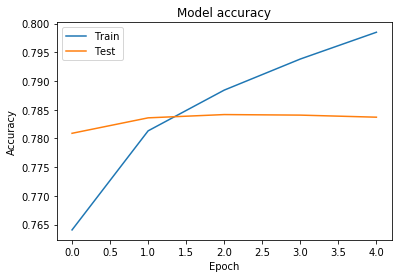

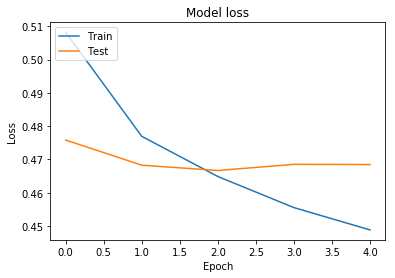

In [ ]:
plot(history)

## GloVe

In [ ]:
embeddings_index = {}
glove_data = 'lib/glove.6B.200d.txt'
f = open(glove_data,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
##
##
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print('embed')


Found 400000 word vectors.
embed


In [ ]:
model=getModel(100000, 200, embedding_matrix, 70, traina)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 200)           20000000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 70, 32)            12832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 35, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 17, 64)            0         
__________

In [ ]:
saveModel(model,"lib/model_glove_eng.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_glove.hdf5',input_train,target_train,input_val,target_val,ep,bs)

Train on 1296757 samples, validate on 324190 samples
Epoch 1/5
1296757/1296757 [==============================] - 741s 571us/step - loss: 0.5115 - categorical_accuracy: 0.7600 - val_loss: 0.4790 - val_categorical_accuracy: 0.7807

Epoch 00001: val_categorical_accuracy improved from -inf to 0.78066, saving model to lib/weights_glove.hdf5
Epoch 2/5
1296757/1296757 [==============================] - 696s 536us/step - loss: 0.4751 - categorical_accuracy: 0.7822 - val_loss: 0.4731 - val_categorical_accuracy: 0.7815

Epoch 00002: val_categorical_accuracy improved from 0.78066 to 0.78150, saving model to lib/weights_glove.hdf5
Epoch 3/5
1296757/1296757 [==============================] - 701s 541us/step - loss: 0.4608 - categorical_accuracy: 0.7902 - val_loss: 0.4707 - val_categorical_accuracy: 0.7819

Epoch 00003: val_categorical_accuracy improved from 0.78150 to 0.78193, saving model to lib/weights_glove.hdf5
Epoch 4/5
1296757/1296757 [==============================] - 691s 533us/step - loss

In [ ]:
score('lib/weights_glove.hdf5',input_val,target_val)

In [ ]:
plot(history)

## DBOW

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dbow_eng')
print('loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')


In [ ]:
model=getModel(num_words, 100, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dbow_eng.json")

In [ ]:
history=train(model,lanjut,'lib/weights_dbow.hdf5',input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score('lib/weights_dbow.hdf5',input_val,target_val)

In [ ]:
plot(history)

## DMM

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dmm_eng')
print('loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')


In [ ]:
model=getModel(num_words, 100, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dmm_eng.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dmm.hdf5',input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score('lib/weights_dmm.hdf5',input_val,target_val)

In [ ]:
plot(history)

## DMC

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dmc_eng')
print('loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    #embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])
    embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

In [ ]:
model=getModel(num_words, 100, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dmc_eng.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dmc.hdf5',input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score('lib/weights_dmc.hdf5',input_val,target_val)

In [ ]:
plot(history)

## DBOW - DMM

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dbow_eng')
model_ug_sg = Doc2Vec.load('lib/d2v_dmm_eng')
print('loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])
    #embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

In [ ]:
model=getModel(num_words, 200, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dbow-dmm_eng.json")

In [ ]:
history=train(model,lanjut, "lib/weights_dbow-dmm.hdf5",input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score("lib/weights_dbow-dmm.hdf5",input_val,target_val)

In [ ]:
plot(history)

## DBOW - DMC

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dbow_eng')
model_ug_sg = Doc2Vec.load('lib/d2v_dmc_eng')
print('loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])
    #embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

In [ ]:
model=getModel(num_words, 200, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dbow-dmc_eng.json")

In [ ]:
history=train(model,lanjut, "lib/weights_dbow-dmc.hdf5",input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score("lib/weights_dbow-dmc.hdf5",input_val,target_val)

In [ ]:
plot(history)

## DMM - DMC

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dmm_eng')
model_ug_sg = Doc2Vec.load('lib/d2v_dmc_eng')
print('loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])

num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

In [ ]:
model=getModel(num_words, 200, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dmm-dmc_eng.json")

In [ ]:
history=train(model,lanjut, "lib/weights_dmm-dmc.hdf5",input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score("lib/weights_dmm-dmc.hdf5",input_val,target_val)

In [ ]:
plot(history)

## DBOW - DMM - DMC

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dbow_eng')
model_ug_sg = Doc2Vec.load('lib/d2v_dmm_eng')
model_ug_sg1 = Doc2Vec.load('lib/d2v_dmc_eng')
print('loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append((np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])),model_ug_sg1.wv[w])
    

num_words = 100000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

In [ ]:
model=getModel(num_words, 300, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dbow-dmm-dmc_eng.json")

In [ ]:
history=train(model,lanjut, "lib/weights_dbow-dmm-dmc.hdf5",input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score("lib/weights_dbow-dmm-dmc.hdf5",input_val,target_val)

In [ ]:
plot(history)